# 금융분석
 * 주식 시뮬레이션 1
 * 저가에 매수 고가에 매도
 * 데일리 트레이더- 일일 매매 전략
 * 오리온(주) 테스트


In [3]:
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup as bsp
import matplotlib as mpl
import matplotlib.pyplot as plt
import sqlite3

In [4]:
code=271560
pgno=2
url='https://finance.naver.com/item/sise_day.nhn?code={0}&page={1}'
tgurl=url.format(code,pgno)
tgurl

'https://finance.naver.com/item/sise_day.nhn?code=271560&page=2'

In [14]:
def getDB():
    dbname='stockdata.db'
    with sqlite3.connect(dbname) as conn:
        cur=conn.cursor()
        sql='select * from stockp order by skey asc'
        qry=cur.execute(sql)
        desc=[row[0] for row in qry.description]
        data=qry.fetchall()
    return((desc,data))

In [15]:
res=getDB()
res[0]

['sidx', 'skey', 'sday', 'sopen', 'shigh', 'slow', 'sclose', 'svol']

In [17]:

df=pd.DataFrame(data=res[1],columns=res[0]).set_index('sidx')
df.head()

skey        sday  sopen  shigh   slow  sclose     svol
sidx                                                            
895   20170707  2017-07-07  87100  89700  75700   82300  1619864
894   20170710  2017-07-10  82300  88000  81000   88000   840451
893   20170711  2017-07-11  88000  88000  82700   82800   422303
892   20170712  2017-07-12  83700  84600  80000   83500   238407
891   20170713  2017-07-13  83400  84000  80800   81600   218138

<AxesSubplot:xlabel='sday'>

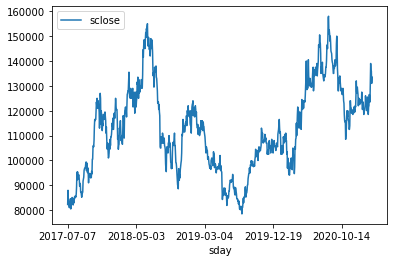

In [18]:
df.plot.line(x='sday',y='sclose')

In [24]:
cdf=df[['sday','sclose']].copy()
cdf.head()

sday  sclose
sidx                    
895   2017-07-07   82300
894   2017-07-10   88000
893   2017-07-11   82800
892   2017-07-12   83500
891   2017-07-13   81600

In [27]:
cdf['preday']=cdf['sclose'].shift(1)
cdf=cdf.fillna(0)
cdf.head()

sday  sclose   preday
sidx                             
895   2017-07-07   82300      0.0
894   2017-07-10   88000  82300.0
893   2017-07-11   82800  88000.0
892   2017-07-12   83500  82800.0
891   2017-07-13   81600  83500.0

In [34]:
cdf.loc[895,'sclose']>cdf.loc[895,'preday']

True

In [37]:
cdf['updown']=(cdf['sclose']>cdf['preday']).astype(int)
cdf.head()

sday  sclose   preday  updown
sidx                                     
895   2017-07-07   82300      0.0       1
894   2017-07-10   88000  82300.0       1
893   2017-07-11   82800  88000.0       0
892   2017-07-12   83500  82800.0       1
891   2017-07-13   81600  83500.0       0

In [39]:
cdf['preupdown']=cdf['updown'].shift(1)
cdf=cdf.fillna(0)
cdf.head()

sday  sclose   preday  updown  preupdown
sidx                                                
895   2017-07-07   82300      0.0       1        0.0
894   2017-07-10   88000  82300.0       1        1.0
893   2017-07-11   82800  88000.0       0        1.0
892   2017-07-12   83500  82800.0       1        0.0
891   2017-07-13   81600  83500.0       0        1.0

### 투자 포인트 설정
* 즉시 매도 매수 포지션
* updown: 전일보다 상승 했는가?
* preupdown: 전일 상승 중이었는가?
* sellpos: 전일보다 상승 했으면 매수1 전일보다 하락했으면 매도-1 하락중이거나 상승중이면 홀드0

In [57]:
cdf['sellpos']= np.where(cdf['updown']>cdf['preupdown'],1,0)+np.where(cdf['updown']<cdf['preupdown'],-1,0)
cdf.head()

sday  sclose   preday  updown  preupdown  sellpos
sidx                                                         
895   2017-07-07   82300      0.0       1        0.0        1
894   2017-07-10   88000  82300.0       1        1.0        0
893   2017-07-11   82800  88000.0       0        1.0       -1
892   2017-07-12   83500  82800.0       1        0.0        1
891   2017-07-13   81600  83500.0       0        1.0       -1

### 거래 가치 분석
* deb 통장잔고: 현찰
* instock 주식잔고: 주식보유수 
* cre 주식 가치:

In [79]:
def finprs(df):
    fdf=df.copy()
    precre=0 # 이전 주식 잔고
    predeb=1000000 # 이전 통장 잔고
    prestock=0
    for idx,row in fdf.iterrows():
         # 살수 있는 주식의 갯수
        #사라는 신호가 왔고 주식잔고는 없다  통장에 잔고(주식을 살만한)가 있는지?
        if (row.loc['sellpos']==1 and prestock==0):
            canbuy=predeb//row.loc['sclose']
            if(canbuy>0):
                #산다
                cre=precre+canbuy*row.loc['sclose']
                deb=predeb-canbuy*row.loc['sclose']
                instock=canbuy
            else:# 돈없어서 아무일 없다
                instock=prestock
                cre=precre
                deb=predeb                
        # 팔라는 신호가 왔고 주식은 있다---> 판다
        elif (row.loc['sellpos']==-1 and prestock>0):
            cre=0
            deb=predeb+row.loc['sclose']*prestock
            instock=0
            # sellpos:1 prestock:1,sellpos:-1 prestock:0, no debt
        else:# 조건이 안맞아서 아무일 없다.
            instock=prestock
            cre=precre
            deb=predeb
        fdf.loc[idx,'hasstock']=instock
        fdf.loc[idx,'debt']=deb
        fdf.loc[idx,'credit']=cre
        prestock=instock
        precre=cre
        predeb=deb
    return fdf
rdf=finprs(cdf)
rdf.head(20)

sday  sclose   preday  updown  preupdown  sellpos  hasstock  \
sidx                                                                      
895   2017-07-07   82300      0.0       1        0.0        1      12.0   
894   2017-07-10   88000  82300.0       1        1.0        0      12.0   
893   2017-07-11   82800  88000.0       0        1.0       -1       0.0   
892   2017-07-12   83500  82800.0       1        0.0        1      12.0   
891   2017-07-13   81600  83500.0       0        1.0       -1       0.0   
890   2017-07-14   81000  81600.0       0        0.0        0       0.0   
889   2017-07-17   82200  81000.0       1        0.0        1      11.0   
888   2017-07-18   83300  82200.0       1        1.0        0      11.0   
887   2017-07-19   84600  83300.0       1        1.0        0      11.0   
886   2017-07-20   80500  84600.0       0        1.0       -1       0.0   
885   2017-07-21   81200  80500.0       1        0.0        1      11.0   
884   2017-07-24   83000  81200.0       1        1.0        0      11.0   
883   2017-07-25   83300  83000.0       1        1.0        0      11.0   
882   2017-07-26   85100  83300.0       1        1.0        0      11.0   
881   2017-07-27   84200  85100.0       0        1.0       -1       0.0   
880   2017-07-28   84800  84200.0       1        0.0        1      11.0   
879   2017-07-31   82100  84800.0       0        1.0       -1       0.0   
878   2017-08-01   83500  82100.0       1        0.0        1      11.0   
877   2017-08-02   82900  83500.0       0        1.0       -1       0.0   
876   2017-08-03   83700  82900.0       1        0.0        1      11.0   

           debt     credit  
sidx                        
895     12400.0   987600.0  
894     12400.0   987600.0  
893   1006000.0        0.0  
892      4000.0  1002000.0  
891    983200.0        0.0  
890    983200.0        0.0  
889     79000.0   904200.0  
888     79000.0   904200.0  
887     79000.0   904200.0  
886    964500.0        0.0  
885     71300.0   893200.0  
884     71300.0   893200.0  
883     71300.0   893200.0  
882     71300.0   893200.0  
881    997500.0        0.0  
880     64700.0   932800.0  
879    967800.0        0.0  
878     49300.0   918500.0  
877    961200.0        0.0  
876     40500.0   920700.0

In [80]:
rdf.tail(10)

sday  sclose    preday  updown  preupdown  sellpos  hasstock  \
sidx                                                                       
25    2021-02-08  122000  121500.0       1        1.0        0       4.0   
24    2021-02-09  126500  122000.0       1        1.0        0       4.0   
23    2021-02-10  125000  126500.0       0        1.0       -1       0.0   
22    2021-02-15  123500  125000.0       0        0.0        0       0.0   
21    2021-02-16  131500  123500.0       1        0.0        1       4.0   
20    2021-02-17  139000  131500.0       1        1.0        0       4.0   
19    2021-02-18  135500  139000.0       0        1.0       -1       0.0   
18    2021-02-19  136000  135500.0       1        0.0        1       4.0   
17    2021-02-22  131000  136000.0       0        1.0       -1       0.0   
16    2021-02-23  133500  131000.0       1        0.0        1       3.0   

          debt    credit  
sidx                      
25     34100.0  486000.0  
24     34100.0  486000.0  
23    534100.0       0.0  
22    534100.0       0.0  
21      8100.0  526000.0  
20      8100.0  526000.0  
19    550100.0       0.0  
18      6100.0  544000.0  
17    530100.0       0.0  
16    129600.0  400500.0

<AxesSubplot:xlabel='sday'>

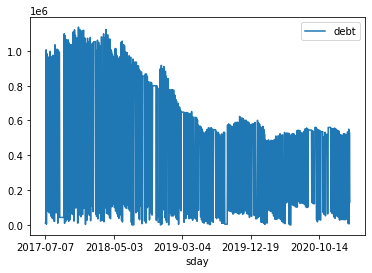

In [81]:
rdf.plot.line(x='sday',y='debt')